In [27]:
import gymnasium as gym
from gym import Env
from gym.spaces import Discrete, Box, Tuple
from pyfmi import load_fmu
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = DymolaEnv()

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [28]:
class DymolaEnv(Env):
    def __init__(self):
        # define action space
        self.action_space = Tuple((
            Box(low=np.array([0.25]), high=np.array([0.8]), dtype=np.float32),
            # Agent 0: Flow_r, Regeneration air flowrate
            Box(low=np.array([1]), high=np.array([100]), dtype=np.float32),
            # Agent 1: N, Rotation speed of Desiccant wheel
            Box(low=np.array([273.15]), high=np.array([353.15]), dtype=np.float32),
        # Agent 2: Tset2, Temperature setpoint of Heater 2
        ))
        # define observation space
        self.observation_space = Box(low=np.array([0]), high=np.array([1]), dtype=np.float32)

        # load fmu file
        self.model = load_fmu("DWHP1_fmu 1.fmu", kind='cs', log_level=2)

        self.output = 30  ## numbers of outputs
        self.start_time = 0  #
        self.end_time = 10 * 3600  #
        self.current_time = self.start_time
        self.step_size = 300  # Define your own step size, unit is second, 300s = 5min
        self.done = False
        self.energy = 0
        self.num_agents = len(self.action_space)
        self.power_ref = 6000.0
        self.Temp_d = 273.15 + 46
        self.RH_d = 0.1

        # Create a list with 30 elements, all of which are 0, using iteration
        zero_list = []
        for _ in range(self.output):
            zero_list.append(0)

        self.state = zero_list
        # Initialize the model with the start time
        self.model.reset()
        self.model.initialize(self.start_time)
        print("success boot")

        # set start temp
        # self.state=np.array([38+random.uniform(-3, 3), 38+random.uniform(-3, 3), 38+random.uniform(-3, 3)])
        # Temparture, Mo
        # self.state=np.array([25.0, 1.0])
        # set shower length
        self.time_id = 0
        self.dt = 0.2
        self.error_thres = 0.001

    def step(self, action):
        # set action parameters
        paras = action
        self.model.set('FLOW_p', paras[0])
        self.model.set('FLOW_r', paras[1])
        self.model.set('N', paras[2])
        self.model.set('SP_HP', paras[3])
        self.model.set('Tset1', paras[4])
        self.model.set('Tset2', paras[5])

        self.model.do_step(self.current_time, self.step_size, True)

        # Caluculate Observation
        observation_all = []

        for i in range(self.output):
            self.state[i] = self.model.get(f"y{i}")[0]
            if i >= 6 and i % 3 != 2:
                observation_all.append(self.state[i])

        # Caluculate Observation
        observation_all = []

        for i in range(self.output):
            self.state[i] = self.model.get(f"y{i}")[0]
            if i >= 6 and i % 3 != 2:
                observation_all.append(self.state[i])

        observation_all.append(self.state[1])
        observation_all.append(self.state[2])
        observation_all.append(self.state[5])

    
        self.obs_env = np.array(observation_all)
        
        #Update Time
        self.current_time += self.step_size

        # Check if time is larger than terminate time setting
        if self.current_time >= self.end_time:
            self.done = True
            self.model.terminate()
            print("dymola model end")
        else:
            self.done = False

        # Apply temperature noise
        # self.state += random.randint(-1,1)
        # Set placeholder for info
        Temp_d = self.Temp_d
        RH_d = self.RH_d

        Temp_fc = self.state[27]
        RH_fc = self.state[28]

        humidity_error = abs(RH_d - RH_fc)
        temp_error = abs(Temp_d - Temp_fc)

        # calculate power
        power = 0
        for i in range(6):
            power += self.state[i]

        self.energy += power * self.step_size

        # calculate reward
        if humidity_error < 0.005:
            hum_reward = 1
        else:
            hum_reward = -1

        if temp_error < 1:
            temp_reward = 1
        else:
            temp_reward = -1

        power_reward = (self.power_ref - power) / self.power_ref

        reward_all = hum_reward + temp_reward + power_reward

        reward = reward_all
        done = self.done
    

        info = {}

        # return step information
        return self.obs_env, reward, done, info

    def render(self):
        print(self.state)
        pass

    def reset(self):
        # Initialize the model with the start time

        if self.current_time >= self.end_time:
            self.model = load_fmu("DWHP1_fmu 1.fmu", kind='cs', log_level=2)
            self.model.reset()
            self.model.initialize(self.start_time)
            self.current_time = 0
            self.energy = 0
            self.done = False
            print("Normal end: time reset")

        if self.current_time>0:
            if not self.done:
                self.model.terminate()
                self.model = load_fmu("DWHP1_fmu 1.fmu", kind='cs', log_level=2)
                self.model.reset()
                self.model.initialize(self.start_time)
                self.current_time = 0
                self.energy = 0
                self.done = False
                print("Error end: time reset")



        # Caluculate Observation
        observation_all = []

        for i in range(self.output):
            self.state[i] = self.model.get(f"y{i}")[0]
            if i >= 6 and i % 3 != 2:
                observation_all.append(self.state[i])

        observation_all.append(self.state[1])
        observation_all.append(self.state[2])
        observation_all.append(self.state[5])

    
        self.obs_env = np.array(observation_all)

        info = []


        print("reset activate")
        return self.obs_env, info

In [18]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [19]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [20]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = len(env.action_space)
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(6000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [21]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        print("no learning")
        return
    print("start learning")
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [22]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 1
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    print(f"state: {type(state)},{state}")
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    print(count())
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        print(t)
        print(f"state: {type(state)},{state}")
        print(f"action: {type(action.item())},{action.item()}")
        print(f"observation: {type(observation)},{observation}")
        print(f"reward: {type(reward)}{reward}")

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            print('break')
            #plot_durations()
            break

#print('Complete')
#plot_durations(show_result=True)
#plt.ioff()
#plt.show()

state: <class 'numpy.ndarray'>,[ 0.02746198 -0.03521593  0.03115232 -0.00927336]
count(0)
0
state: <class 'torch.Tensor'>,tensor([[ 0.0275, -0.0352,  0.0312, -0.0093]], device='cuda:0')
action: <class 'int'>,1
observation: <class 'numpy.ndarray'>,[ 0.02675766  0.15944573  0.03096686 -0.29196686]
reward: <class 'torch.Tensor'>tensor([1.], device='cuda:0')
no learning
1
state: <class 'torch.Tensor'>,tensor([[ 0.0268,  0.1594,  0.0310, -0.2920]], device='cuda:0')
action: <class 'int'>,1
observation: <class 'numpy.ndarray'>,[ 0.02994658  0.35411277  0.02512752 -0.5747246 ]
reward: <class 'torch.Tensor'>tensor([1.], device='cuda:0')
no learning
2
state: <class 'torch.Tensor'>,tensor([[ 0.0299,  0.3541,  0.0251, -0.5747]], device='cuda:0')
action: <class 'int'>,1
observation: <class 'numpy.ndarray'>,[ 0.03702883  0.5488736   0.01363302 -0.859387  ]
reward: <class 'torch.Tensor'>tensor([1.], device='cuda:0')
no learning
3
state: <class 'torch.Tensor'>,tensor([[ 0.0370,  0.5489,  0.0136, -0.85

In [7]:
print(action)

tensor([[0]], device='cuda:0')


In [8]:
print(state)

None


In [8]:
A=torch.tensor([1])

In [10]:
print(A.unsqueeze(0))

tensor([[1]])


In [36]:
np.random.rand(2)

array([0.54192006, 0.08770577])

Generated Matrix:
[ 1.32018871  1.07587971  0.79650708 -0.90382416  0.17051513]


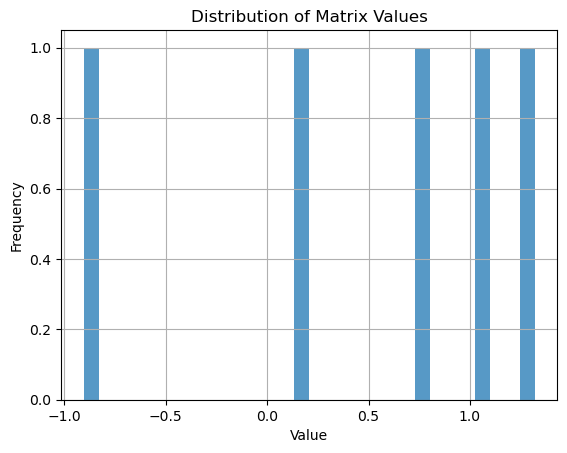

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a 5x5 matrix from the standard normal distribution
matrix = np.random.randn(5)

# Print the generated matrix
print("Generated Matrix:")
print(matrix)

# Plotting the distribution of the matrix values
plt.hist(matrix.flatten(), bins=30, alpha=0.75)
plt.title("Distribution of Matrix Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dim = 4
action_dim = 1
hidden_size = 256
lr_actor = 1e-4
lr_critic = 1e-3

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_dim),
            nn.Tanh()  # assuming actions are scaled to [-1, 1]
        )

    def forward(self, state):
        return self.net(state)

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=-1))

class GaussianNoise:
    def __init__(self, action_dimension, scale=0.2):
        self.action_dimension = action_dimension
        self.scale = scale

    def noise(self):
        return np.random.normal(0, self.scale, self.action_dimension)

class DDPGAgent:
    def __init__(self, state_dim, action_dim, hidden_size):
        self.actor = Actor(state_dim, action_dim, hidden_size).to(device)
        self.critic = Critic(state_dim, action_dim, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.noise = GaussianNoise(action_dim)

    def select_action(self, state):
        self.actor.eval()
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            action = self.actor(state).cpu().data.numpy()
        self.actor.train()
        return action + self.noise.noise()

# Example usage
agent = DDPGAgent(state_dim, action_dim, hidden_size)
state = np.random.randn(state_dim)
action = agent.select_action(state)
print("Sampled action:", action)


Sampled action: [-0.098006]


In [48]:
agent.noise.scale

0.2

In [51]:
agent.noise.action_dimension

1